# The ML Pipeline: Categorical Data and Assessing Performance
```{jupyter-info}
{rel-data-download}`BankChurners.csv`
```

# Recap 
In the last lesson, we were introduced to the idea of machine learning. We saw how to write code to load in data, separate it into features and labels, train a model on that data, assess its accuracy. We commonly call these steps (or any modification of them) the **machine learning pipeline**. We think of it acting like a pipe, connecting data to the final model that can make predictions from it.

In the last reading, we ended up seeing our model had 100% accuracy on the data which seemed great at first, but in this lesson, we will see it's less than ideal. Before describing this in detail, let's do a slight recap of what we saw last time but with a slightly different dataset.

For this lesson, we will consider a dataset concerning customers of a particular credit card agency, and whether or not those customers decided to close their credit card (also called "churn"). We won't go into the specifics of what all the columns mean, since they are mostly specific to financial records. The one term that is important is the label we are trying to predict in the `Attrition_Flag` column where `'Existing Customer'` means the customer has kept their account, while `'Attrited Customer'` is one that has closed their account.

To start, we load in the dataset.

In [149]:
import pandas as pd

data = pd.read_csv('BankChurners.csv')

data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal
0,Existing Customer,45.0,F,NaN,Graduate,Married,Unknown,Blue,37.0,6.0,1.0,2.0,14470.0,1157.0
1,Existing Customer,53.0,M,3.0,Graduate,Unknown,$80K - $120K,Blue,49.0,5.0,2.0,1.0,4778.0,1869.0
2,Existing Customer,56.0,F,3.0,NaN,Married,Less than $40K,Blue,47.0,6.0,3.0,4.0,2865.0,2022.0
3,Existing Customer,26.0,F,0.0,Post-Graduate,Single,Less than $40K,Blue,13.0,5.0,3.0,2.0,2902.0,1668.0
4,Existing Customer,44.0,F,3.0,Uneducated,Single,$40K - $60K,Blue,34.0,3.0,3.0,3.0,2245.0,1342.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4062,Attrited Customer,55.0,F,3.0,Uneducated,Single,Unknown,Blue,47.0,4.0,3.0,3.0,14657.0,2517.0
4063,Attrited Customer,41.0,M,2.0,Unknown,Divorced,$40K - $60K,Blue,25.0,4.0,2.0,3.0,4277.0,2186.0
4064,Attrited Customer,44.0,F,1.0,High School,Married,Less than $40K,Blue,36.0,5.0,3.0,4.0,5409.0,0.0
4065,Attrited Customer,30.0,M,2.0,Graduate,Unknown,$40K - $60K,Blue,36.0,4.0,3.0,3.0,5281.0,0.0


Now this already looks slightly different than the dataset we saw in Lesson 10!
* Some of the columns, like 'Gender' and 'Educational Data' don't store numbers, but rather categorical data like "F" or "M".
* Some of the rows store missing values!

Our first step is to remove the missing values because `sklearn` does not handle missing values well. In this problem, we will be using all columns as features, it suffices to just drop a row if it contains any `NaN` values (which is what `dropna` does). In other contexts, you might need to be more careful about which rows you drop, since you only need to drop ones that would eventually be included in the feaures you use in `sklearn`.

Remember, we have to save the result of `dropna` because it doesn't modify the original data!

In [150]:
data = data.dropna()

Our next step is to separate the features and labels.

In [151]:
features = data.loc[:, data.columns != 'Attrition_Flag']
labels = data['Attrition_Flag']

We then create a decision tree model and train it on the data.

In [152]:
# Import the model and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Create an untrained model
model = DecisionTreeClassifier()

# Train it
model.fit(features, labels)

# Make predictions
label_predictions = model.predict(features)

# Print accuracy
print('Accuracy:', accuracy_score(labels, label_predictions))

ValueError: could not convert string to float: 'M'

Uh oh! Something broke! As we mentioned earlier, the dataset has categorical values than quantitative values for some columns. This ends up causing problems for `sklearn` since it assumes all feature values are numeric! 

To fix this, we need to understand how to handle categorical features for machine learning.

# Categorical Features
For this section, let's suppose we had a smaller dataset that only stored a column for `age` and another column for `gender`. We can see this sample dataset here.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age</th>
      <th>gender</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>22.0</td>
      <td>male</td>
    </tr>
    <tr>
      <th>1</th>
      <td>38.0</td>
      <td>female</td>
    </tr>
    <tr>
      <th>2</th>
      <td>26.0</td>
      <td>non-binary</td>
    </tr>
    <tr>
      <th>3</th>
      <td>35.0</td>
      <td>female</td>
    </tr>
    <tr>
      <th>4</th>
      <td>35.0</td>
      <td>male</td>
    </tr>
  </tbody>
</table>


Let's consider some strategies for how to address that the `gender` column is categorical. Your first guess might be to come up with some mapping between the categories to a number. Suppose the `gender` column could be `male`, `female` or `non-binary`. You might propose transforming the data such that 
* $\texttt{`female'} \rightarrow 1$
* $\texttt{`male'} \rightarrow 2$
* $\texttt{`non-binary'} \rightarrow 3$

While doing this will "work" in a sense that the model can be trained, this will cause some unintended consequences for how the model interprets those features. By treating each gender as a number, we are now establishing relationships between the genders that should behave like numbers do. So now we have some non-sensical concepts like:
* `'male' (2)` is considered "greater than" `'female' (1)`! Just like for the age column, an age of 10 is less than an age of 32.
* `'non-binary' (3)` is somehow the same as 3x `'female' (1)`! This is just like for an age column an age of 40 is 4x an age of 10. 

Now this isn't a mistake on the model's part! The model has no concept of `gender`. All the features are just numbers to it, and it expects those numbers to behave as numbers do. 

So if this mapping approach doesn't work, then what does? We will use a slightly more complex techique called a **one-hot encoding**. The idea is as follows: 

Suppose we had this `gender` column that took on values `male`, `female`, and `non-binary`. We will now transform that one column to three: one for `gender_male`, one for `gender_female` and one for `gender_non-binary`. Each column will store 0s and 1s to indicate which category that row belonged to. 

After doing a one-hot encoding of these columns in the sample data shown above, the `gender` column will be expanded into 3 as shown in the table below. Notice that each row has one 1 and the rest 0s for the newly-created `gender_<value>` columns; this is why it's called a "one-hot encoding", one of the columns is "hot" (or 1). Also notice that the `age` column does not need this encoding, because it is already a numeric value.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age</th>
      <th>gender_female</th>
      <th>gender_male</th>
      <th>gender_non-binary</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>22.0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>38.0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>26.0</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>35.0</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>35.0</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
  </tbody>
</table>

Don't worry, you never have to do this by hand! `pandas` provides a function called `get_dummies` that does this for us (a one-hot encoding is sometimes called a dummy encoding)! In the cell below, we show the code to transform the data so the features are no longer categorical! Notice in the output, the previous categorical features now have this one-hot encoding to them!

**Important:** We don't do the `get_dummies` call on the whole dataset `data` because we do not want to one-hot encode the label. `sklearn` is fine with categorical labels, we just need to transform the features.

In [153]:
features = pd.get_dummies(features)
features.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'],
      dtype='object')

# Assessing Accuracy
So now that we have transformed the data, we can go back to the original task of trying to assess how good the model we fit to the data is! In the cell below, we train the model and evaluate its accuracy on the data.

In [154]:
# Create an untrained model
model = DecisionTreeClassifier()

# Train it
model.fit(features, labels)

# Make predictions
label_predictions = model.predict(features)

# Print accuracy
print('Accuracy:', accuracy_score(labels, label_predictions))

Accuracy: 1.0


And look at that! Another job well done since we also get 100% accuracy here as well! 

Unfortunately, the story gets more complicated than this and we should **not** expect the model to predict 100% accurately on future data. We didn't emphasize this before, but the goal of machine learning is generally learn a model that predicts accurately for **future, unseen data** (if we want it to be useful to people using it). 

It turns out that our strategy for assessment so far is a bit optimistic (i.e., overestimates) on the model's future performance. The model we learned in the last cell is actually **overfit** to the training set, meaning that it was capable of "memorizing" the data in the training set, and thus getting a perfect score when we then tested it using that set.

The analogy for why this happens is much like a common experience as students when studying for something like an exam.

Suppose I told you I was going to give you a multiple choice quiz on ML topics tomorrow, but you can use a practice exam (with answers) to study tonight as much as you want. You might spend a few hours studying until you feel really confident about the answers on the practice exam. If you were able to get 100% of the practice questions after studying them for a few hours, would you also expect to get 100% of the real test questions correct? 

We might be a little pessimistic that you would not get 100% on the real exam just because you aced the practice exam after studying it for a few hours. An "easy" way to get 100% on this practice exam is to just spend a ton of time memorizing the answers for those specifics questions. Sure, if I gave you that question on the real test, you would do great, but if I gave you anything else you would have no idea how to answer! 

This is essentially what is happening to our assessment of our model! We gave it the practice exam (the training set) to practice (train) and then are using that exact same practice exam (the training set) to assess how we think it will do on the real exam (when deploying it to the world). This will be an overestimate of how it will do in the future since it was able to shape its knowledge around that exact training set. 

Instead, if we want to estimate how we think the model will do in the future, we will need to *hold out* data that it will never see during training and then test it on that data set. We call this held-out data the **test set**. 

Here is one of the most important rules in all of machine learning:

> **You need to set aside some data that you never look at while training to assess how your model will do in the future.**

Because this is so important, `sklearn` provides a function called `train_test_split` to break your dataset up (randomly) into a training set and test set. It's actually important to generally use a random split, since some data can be naturally sorted by some column which would cause a difference in distribution between training and test. For example, in this credit card dataset, if we took the last 20% of the rows to be the test set, that would be mostly the Attrited Customers examples since they are sorted by the label in the original data.

The cell below shows how to call it. It is a bit weird since it returns a tuple and we unpack it into variables in a very specific order.

In [155]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2)

# Print the number of training examples and the number of testing examples
print(len(features_train), len(features_test))

3098 775


Now we repeat our ML pipeline from before with two important differences:
* We now train on `features_train` and `labels_train` instead of the entire data
* We print out both the accuracy on the training set and the accuracy on the test set

In [156]:
# Create an untrained model
model = DecisionTreeClassifier()

# Train it on the **training set**
model.fit(features_train, labels_train)

# Compute training accuracy
train_predictions = model.predict(features_train)
print('Train Accuracy:', accuracy_score(labels_train, train_predictions))

# Compute test accuracy
test_predictions = model.predict(features_test)
print('Test  Accuracy:', accuracy_score(labels_test, test_predictions))

Train Accuracy: 1.0
Test  Accuracy: 0.6967741935483871


Wow! While we got 100% of the training examples correct, we only got a ~68-72% on the test set! Note there is some randomness in your result since the train/test split is random and the learning algorithm used by the decision tree classifier also has some randomness built into it.

This test accuracy is a MUCH better estimate of how our model will do in the future if we released it to the world since it is being tested on data it hasn't seen before (a proxy for future data).

Why is there this discrepency between train and test anyways? This results from the fact that our model is **overfitting**. **Overfitting** happens when a model does too good of a job fitting to the specific training set given to it rather than learning generalizable patterns. In the test-taking analogy, a student overfits to a practice exam if they focus on memorizing the answers on the practice test rather than learning the generalized ideas.

With everything we have seen so far (except the stuff about categorical features), you can now go back to the [Introduction to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/#classify-test-data) we read last time and read the "Reality Check" part and beyond. Go read it! Their visualizations hopefulyl make it clear why these splits near the bottom of the tree, are more likely to contain irrelevant details.

# Why do Trees Overfit?

Why does the tree overfit in this context and how can we prevent that? Overfitting happens for decision trees by default since we allow the tree to grow really tall! 

We aren't able to use the code from the last lesson to actually visualize the tree we learned, because it's actually quite large! 

If you think back to the R2D3 reading and how the decision tree is learned, they successively decide to split the data based on some feature and then build up the tree and separating the data as they go down. Notice, for example, that at the bottom of the tree, it is making decisions about splits for VERY few data points. This is because earlier forks split the data relatively evenly. This means that after enough splits when it is at the bottom of the tree, the learning algorithm is essentially making decisions on splits from basically just noise in the data. The fact that this tree is allowed to be as tall as it wants, lets it makes splits until it gets the training set 100% correct! 

To control for overfitting, we can specify a **hyperparameter** to control the height the tree is allowed to grow. We call this value a hyperparameter because it is something you (the ML expert) can specify to the learning algorithm to control how complex you want the model to be. 

For example, the cell below trains the same type of model on the same training set, but it passes a `max_depth` to the `DecisionTreeClassifier` to control how tall the tree should be allowed to grow. By passing in 2, we are only allowing the model to be tall enough to reach an answer in at most 2 steps. In this cell, we print both the training and test accuracy as well as plotting the tree in the following cell.

In [157]:
# Create an untrained model
short_model = DecisionTreeClassifier(max_depth=2)

# Train it on the **training set**
short_model.fit(features_train, labels_train)

# Compute training accuracy
train_predictions = short_model.predict(features_train)
print('Train Accuracy:', accuracy_score(labels_train, train_predictions))

# Compute test accuracy
test_predictions = short_model.predict(features_test)
print('Test  Accuracy:', accuracy_score(labels_test, test_predictions))

Train Accuracy: 0.7588766946417044
Test  Accuracy: 0.7458064516129033


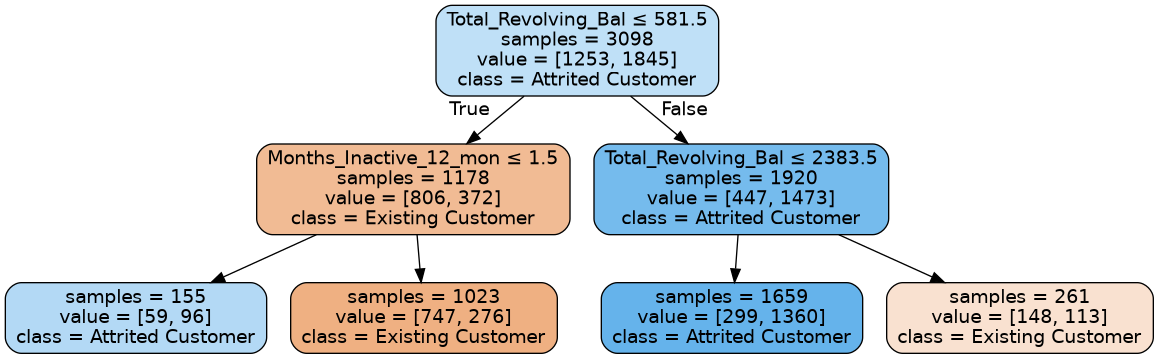

In [158]:
from IPython.display import Image, display

import graphviz 
from sklearn.tree import export_graphviz


def plot_tree(model, features, labels):
    dot_data = export_graphviz(model, out_file=None, 
            feature_names=features.columns,  
            class_names=labels.unique(),
            impurity=False,
            filled=True, rounded=True,  
            special_characters=True) 
    graphviz.Source(dot_data).render('tree.gv', format='png')
    display(Image(filename='tree.gv.png'))

# Import 
plot_tree(short_model, features_train, labels_train)

This tree has depth 2, so it is actually possible for us to visualize. Interestingly, the train accuracy and test accuracy have now gotten closer together. It still makes sense that the train accuracy is slightly higher than the test since we did get to look at that data while training, but by limiting the depth we prevented the model from overfitting as much to the training data.

This hyperparameter for controlling the height controls the **model complexity**. On one end, short trees are simple (i.e., not complex) and they are unable to fit the training set well. This prevents overfitting, but might still result in a bad model since it doesn't have the capacity to learn a complex set of rules. On the other hand, if the tree is allowed to be too tall, it will easily overfit to the training set and will generalize poorly due to that overfitting. 

The right choice is somewhere in the middle, but there is no principled answer for where. This tradeoff is commonly called the "bias-variance tradeoff". 

To summarize this
* Models that are too simple generally have low train accuracy and low test accuracy because they are not able to learn a complex-enough set of rules.
* Models that are too complex generally have high train accuracy and low test accuracy because they overfit to the training set.

The following code cell tries to demonstrate empirically this phenomena by training models with various `max_depths` and plotting their train and test accuracies as a function of the `max_depth`. 

**You do not need to understand the code in this cell, but do look at the visualization below.**

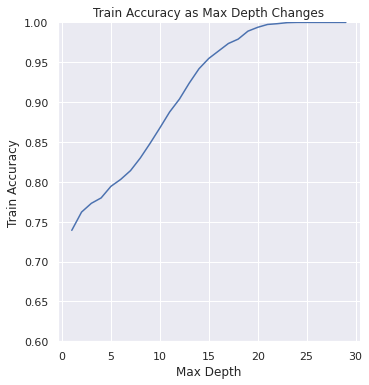

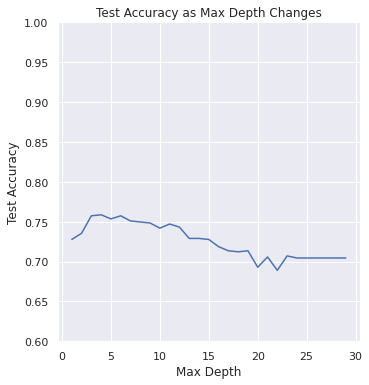

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# We re-split the data and put a "random state" to make the results
# not actually random for demonstration purposes. 
# You should not use random_state in your assessments or project.
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2, random_state=2)

accuracies = []
for i in range(1, 30):
    model = DecisionTreeClassifier(max_depth=i, random_state=1)
    model.fit(features_train, labels_train)

    pred_train = model.predict(features_train)
    train_acc = accuracy_score(labels_train, pred_train)

    pred_test = model.predict(features_test)
    test_acc = accuracy_score(labels_test, pred_test)

    accuracies.append({'max depth': i, 'train accuracy': train_acc, 
                       'test accuracy': test_acc})
accuracies = pd.DataFrame(accuracies)


# Define a function to plot the accuracies

def plot_accuracies(accuracies, column, name):
    """
    Parameters:
        * accuracies: A DataFrame show the train/test accuracy for various max_depths
        * column: Which column to plot (e.g., 'train accuracy')
        * name: The display name for this column (e.g., 'Train')
    """
    sns.relplot(kind='line', x='max depth', y=column, data=accuracies)
    plt.title(f'{name} Accuracy as Max Depth Changes')
    plt.xlabel('Max Depth')
    plt.ylabel(f'{name} Accuracy')
    plt.ylim(0.6, 1)

    plt.show()  # Display the graph

# Plot the graphs
plot_accuracies(accuracies, 'train accuracy', 'Train')
plot_accuracies(accuracies, 'test accuracy', 'Test')

You can see from these graphs, that empirically we can see this bias-variance tradeoff.
* When the model is too simple (`max_depth` is near 1), the training accuracy and test accuracy are closer together, but are quite low when compared to our initial 100% claim on the training accuracy. This is commonly called **underfitting**.
* As the complexity increases (`max_depth` is increasing) the train and test accuracies do slightly different things:
  * The training accuracy is always going up. This is because we are giving the model more room to grow, resulting in a more complex model. This extra complexity allows it to perfectly fit the training set in the extreme of `max_depth` > 20.
  * The test accuracy is very interesting. It starts by increasing to its highest point around `max_depth=5` and then starts decreasing. This is because before `max_depth=5`, the model was too simple for the task (e.g, underfit) but after `max_depth=5` the model starts to overfit (e.g, too complex for the task). 
  
# Optional: Visiualizing the Bias Variance Tradeoff
The authors of that article we read last time made a follow up post describing this tradeoff. You can read it from the link below (but doing so is not required). Do note one very important difference in terminology.

> In the article, they use the term **parameter** instead of **hyperparameter**. This is not their fault, they just use different terminology (everyone uses slightly different terms). When we come back to ML later in the quarter, we will be very particular with our usage of those two words so you should read their usage of the word "parameter" as our "hyperparameter".

[Link to article](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)

[Here is another article](http://scott.fortmann-roe.com/docs/BiasVariance.html) that explains this idea.